In [ ]:
# --- Library Import --- #

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

device = 'cpu'

In [ ]:
# --- Grid Cell Network Model --- #

class GridCellNet(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, linear_size=512, n_place=256, n_hd=36, dropout_p=0.5):
        super().__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

        self.linear = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(hidden_size, linear_size)  # No activation function
        )

        self.out_place = nn.Linear(linear_size, n_place)
        self.out_hd = nn.Linear(linear_size, n_hd)

        self.W_cp = nn.Linear(n_place, hidden_size, bias=False)
        self.W_cd = nn.Linear(n_hd, hidden_size, bias=False)
        self.W_hp = nn.Linear(n_place, hidden_size, bias=False)
        self.W_hd = nn.Linear(n_hd, hidden_size, bias=False)

        self.clip_value = 1.0  # Gradient clipping

        self.reset_parameters()

    def reset_parameters(self):
        """ 논문에서 언급된 방식으로 가중치 초기화 """
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)  # Xavier Uniform 초기화

        for name, param in self.lstm.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                nn.init.zeros_(param)  # Bias는 0으로 초기화

    def forward(self, x, init_place, init_hd):
        h0 = self.W_cp(init_place) + self.W_cd(init_hd)
        c0 = self.W_hp(init_place) + self.W_hd(init_hd)
        h0, c0 = h0.unsqueeze(0), c0.unsqueeze(0)

        lstm_out, _ = self.lstm(x, (h0, c0))
        g = self.linear(lstm_out)

        place_pred = torch.softmax(self.out_place(g), dim=-1)
        hd_pred = torch.softmax(self.out_hd(g), dim=-1)

        return place_pred, hd_pred, g

# --- Utility Functions ---
def simulate_trajectory(T, arena_size, dt=0.1, 
                                velocity_mean=15.0, velocity_std=3.0, 
                                angular_std=0.2, wall_margin=0.1):

    pos = np.zeros((T, 2))
    angle = np.random.uniform(0, 2 * np.pi)
    velocity = np.random.normal(velocity_mean, velocity_std)

    # 초기 위치 설정
    pos[0] = np.random.uniform(wall_margin, arena_size - wall_margin, size=2)

    for t in range(1, T):
        # 방향 변경 (자연스럽게)
        angle += np.random.normal(0, angular_std)

        # 이동 거리 계산
        dx = velocity * dt * np.cos(angle)
        dy = velocity * dt * np.sin(angle)
        new_pos = pos[t - 1] + [dx, dy]

        # 벽 근처에 도달하면 방향 튜닝 (더 부드럽게)
        for i in [0, 1]:  # x축과 y축
            if new_pos[i] < wall_margin:
                new_pos[i] = wall_margin
                angle += np.pi / 2  # 반대 방향으로 꺾음
            elif new_pos[i] > arena_size - wall_margin:
                new_pos[i] = arena_size - wall_margin
                angle += np.pi / 2

        pos[t] = new_pos

    return pos


def generate_place_cells(N, arena_size):
    return np.random.uniform(0, arena_size, size=(N, 2))

def generate_hd_cells(M):
    return np.linspace(-np.pi, np.pi, M, endpoint=False)

def get_place_encoding(pos, centers, sigma=0.2):
    dists = np.linalg.norm(pos[:, None, :] - centers[None, :, :], axis=2)
    encoding = np.exp(-dists**2 / (2 * sigma**2))
    return encoding / (encoding.sum(axis=1, keepdims=True) + 1e-8)

def get_hd_encoding(angles, hd_centers, kappa=20):
    diffs = angles[:, None] - hd_centers[None, :]
    encoding = np.exp(kappa * np.cos(diffs))
    return encoding / (encoding.sum(axis=1, keepdims=True) + 1e-8)


# --- Training Function ---

def find_valid_prev_dir(vel, idx):
    for j in reversed(range(idx + 1)):
        if np.linalg.norm(vel[j]) > 1e-6:
            return vel[j]
    return np.array([1.0, 0.0])  # fallback: x축

def train_path_integration(model, optimizer, place_cell_centers, hd_centers, arena_size, T=1000, epochs=300, batch_size=8,
                           velocity_mean=15.0, velocity_std=3.0, angular_std=0.2):
    
    device = next(model.parameters()).device
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()

        loss_total = 0  # 배치의 총 loss

        for _ in range(batch_size):
            # 🔹 새로운 trajectory 생성
            traj = simulate_trajectory(T, arena_size, velocity_mean=velocity_mean, velocity_std=velocity_std, angular_std=angular_std)

            # 속도 계산
            vel = np.diff(traj, axis=0, prepend=traj[0:1]) / 0.1
            angle = np.arctan2(vel[:, 1], vel[:, 0])
            egocentric_inputs = []

            prev_dir = find_valid_prev_dir(vel, 0)

            for i in range(len(vel)):
                v = vel[i]
                speed = np.linalg.norm(v)

                # 기준 좌표계 생성 (이전 방향 기반)
                forward = prev_dir / (np.linalg.norm(prev_dir) + 1e-8)
                lateral = np.array([-forward[1], forward[0]])

                # egocentric 좌표계에서의 각도
                v_forward = np.dot(v, forward)
                v_lateral = np.dot(v, lateral)
                ego_angle = np.arctan2(v_lateral, v_forward)

                egocentric_inputs.append([speed, np.cos(ego_angle), np.sin(ego_angle)])

                # 방향 갱신 조건: 속도 벡터가 0이 아닐 때만
                if speed > 1e-6:
                    prev_dir = v
                else:
                    prev_dir = find_valid_prev_dir(vel, i)

            inputs = np.array(egocentric_inputs)

            place_target = get_place_encoding(traj, place_cell_centers)
            hd_target = get_hd_encoding(angle, hd_centers)

            # 🔹 PyTorch Tensor 변환
            x = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
            y_place = torch.tensor(place_target, dtype=torch.float32).unsqueeze(0).to(device)
            y_hd = torch.tensor(hd_target, dtype=torch.float32).unsqueeze(0).to(device)

            # 🔹 LSTM 초기 상태 설정 (첫 번째 timestep의 활성화 값 사용)
            init_place = y_place[:, 0, :]
            init_hd = y_hd[:, 0, :]

            # 🔹 모델 예측 수행
            pred_place, pred_hd, _ = model(x, init_place, init_hd)

            # 🔹 Cross-Entropy Loss 계산 (Batch Gradient Update)
            loss_place = -(y_place * torch.log(pred_place + 1e-8)).sum()
            loss_hd = -(y_hd * torch.log(pred_hd + 1e-8)).sum()
            loss = loss_place + loss_hd

            # 🔹 배치 손실 누적
            loss_total += loss / batch_size

        # 🔹 배치 업데이트 수행
        loss_total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), model.clip_value)
        optimizer.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Batch Loss: {loss_total.item():.4f}")


In [ ]:
# --- Test & Plot --- #

def compare_place_hd_activation(model, trajectory, place_target, hd_target, vel, place_cell_centers, hd_centers, num_points=3):
    model.eval()
    device = next(model.parameters()).device

    T = len(trajectory)

    # 속도 및 head angle 계산
    vel = np.diff(trajectory, axis=0, prepend=trajectory[0:1]) / 0.1
    angle = np.arctan2(vel[:, 1], vel[:, 0])

    # Ego-centric input 만들기
    egocentric_inputs = []
    prev_dir = vel[0] if np.linalg.norm(vel[0]) > 1e-6 else find_valid_prev_dir(vel, 0)

    for i in range(len(vel)):
        v = vel[i]
        speed = np.linalg.norm(v)
        forward = prev_dir / (np.linalg.norm(prev_dir) + 1e-8)
        lateral = np.array([-forward[1], forward[0]])
        v_forward = np.dot(v, forward)
        v_lateral = np.dot(v, lateral)
        ego_angle = np.arctan2(v_lateral, v_forward)
        egocentric_inputs.append([speed, np.cos(ego_angle), np.sin(ego_angle)])

        prev_dir = v if speed > 1e-6 else find_valid_prev_dir(vel, i)

    inputs = np.array(egocentric_inputs)
    place_encoding = get_place_encoding(trajectory, place_cell_centers)
    hd_encoding = get_hd_encoding(angle, hd_centers)

    x = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
    y_place = torch.tensor(place_encoding, dtype=torch.float32).unsqueeze(0).to(device)
    y_hd = torch.tensor(hd_encoding, dtype=torch.float32).unsqueeze(0).to(device)

    init_place = y_place[:, 0, :]
    init_hd = y_hd[:, 0, :]

    with torch.no_grad():
        pred_place, pred_hd, _ = model(x, init_place, init_hd)

    pred_place = pred_place[0].cpu().numpy()  # (T, N)
    pred_hd = pred_hd[0].cpu().numpy()        # (T, M)

    selected_timesteps = np.linspace(0, T-1, num_points, dtype=int)
    # 🔹 시각화
    fig, axs = plt.subplots(num_points, 2, figsize=(12, num_points * 4))

    for i, t in enumerate(selected_timesteps):
        # Place Cell
        axs[i, 0].bar(np.arange(place_target.shape[1]), place_target[t], alpha=0.6, label="True", color='blue')
        axs[i, 0].bar(np.arange(place_target.shape[1]), pred_place[t], alpha=0.6, label="Predicted", color='orange')
        axs[i, 0].set_title(f"Place Cell Activation (T={t})")
        axs[i, 0].set_xlabel("Place Cell Index")
        axs[i, 0].set_ylabel("Activation")
        axs[i, 0].legend()

        # Head Direction Cell
        axs[i, 1].bar(np.arange(hd_target.shape[1]), hd_target[t], alpha=0.6, label="True", color='blue')
        axs[i, 1].bar(np.arange(hd_target.shape[1]), pred_hd[t], alpha=0.6, label="Predicted", color='orange')
        axs[i, 1].set_title(f"Head Direction Cell Activation (T={t})")
        axs[i, 1].set_xlabel("HD Cell Index")
        axs[i, 1].set_ylabel("Activation")
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()
    
def decode_place(place_probs, centers):
    return (place_probs @ centers)

def decode_hd(hd_probs, hd_centers):
    x = np.cos(hd_centers) @ hd_probs.T
    y = np.sin(hd_centers) @ hd_probs.T
    return np.arctan2(y, x)

def evaluate_path_integration(model, trajectory, place_cell_centers, hd_centers, arena_size):
    model.eval()
    device = next(model.parameters()).device

    T = len(trajectory)

    # 속도 및 head angle 계산
    vel = np.diff(trajectory, axis=0, prepend=trajectory[0:1]) / 0.1
    angle = np.arctan2(vel[:, 1], vel[:, 0])

    # Ego-centric input 만들기
    egocentric_inputs = []
    prev_dir = vel[0] if np.linalg.norm(vel[0]) > 1e-6 else find_valid_prev_dir(vel, 0)

    for i in range(len(vel)):
        v = vel[i]
        speed = np.linalg.norm(v)
        forward = prev_dir / (np.linalg.norm(prev_dir) + 1e-8)
        lateral = np.array([-forward[1], forward[0]])
        v_forward = np.dot(v, forward)
        v_lateral = np.dot(v, lateral)
        ego_angle = np.arctan2(v_lateral, v_forward)
        egocentric_inputs.append([speed, np.cos(ego_angle), np.sin(ego_angle)])

        prev_dir = v if speed > 1e-6 else find_valid_prev_dir(vel, i)

    inputs = np.array(egocentric_inputs)
    place_encoding = get_place_encoding(trajectory, place_cell_centers)
    hd_encoding = get_hd_encoding(angle, hd_centers)

    x = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
    y_place = torch.tensor(place_encoding, dtype=torch.float32).unsqueeze(0).to(device)
    y_hd = torch.tensor(hd_encoding, dtype=torch.float32).unsqueeze(0).to(device)

    init_place = y_place[:, 0, :]
    init_hd = y_hd[:, 0, :]

    with torch.no_grad():
        pred_place, pred_hd, _ = model(x, init_place, init_hd)

    pred_place = pred_place.squeeze(0).cpu().numpy()
    pred_hd = pred_hd.squeeze(0).cpu().numpy()

    # 위치와 방향 디코딩
    decoded_pos = decode_place(pred_place, place_cell_centers)
    decoded_hd = decode_hd(pred_hd, hd_centers)

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # 위치 plot
    axes[0].plot(trajectory[:, 0], trajectory[:, 1], label="True Trajectory", color='black')
    axes[0].plot(decoded_pos[:, 0], decoded_pos[:, 1], label="Predicted Trajectory", color='red', alpha=0.7)
    axes[0].set_title("Trajectory Comparison")
    axes[0].set_xlim(0, arena_size)
    axes[0].set_ylim(0, arena_size)
    axes[0].legend()

    # head direction plot
    t = np.arange(T)
    axes[1].plot(t, angle, label="True HD", color='blue')
    axes[1].plot(t, decoded_hd, label="Predicted HD", color='orange', alpha=0.7)
    axes[1].set_title("Head Direction Comparison")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def generate_determined_trajectory(start, end, T, arena_size=2.2,
                                   dt=0.1, velocity_mean=15.0, velocity_std=3.0,
                                   angular_std=0.2, wall_margin=0.1):
    """
    start → end 경로를 따르며, 설치류처럼 움직이는 자연스러운 trajectory 생성
    """
    pos = np.zeros((T, 2))
    pos[0] = start
    direction_vector = end - start
    angle = np.arctan2(direction_vector[1], direction_vector[0])
    velocity = np.random.normal(velocity_mean, velocity_std) / 100.0  # m/s

    for t in range(1, T - 1):  # 마지막은 end로 고정
        # 목표를 향해 약간 흔들리며 이동
        angle += np.random.normal(0, angular_std)

        dx = velocity * dt * np.cos(angle)
        dy = velocity * dt * np.sin(angle)
        new_pos = pos[t - 1] + [dx, dy]

        # 벽 회피
        for i in [0, 1]:
            if new_pos[i] < wall_margin:
                new_pos[i] = wall_margin
                angle += np.pi / 2
            elif new_pos[i] > arena_size - wall_margin:
                new_pos[i] = arena_size - wall_margin
                angle += np.pi / 2

        pos[t] = new_pos

    pos[-1] = end  # 도착점 고정
    return pos

def visualize_activation_maps(model, place_cell_centers, hd_centers, arena_size,
                              grid_res=10, T=20, n_paths=10, layer_d=512, device='cpu'):
    model.eval()
    model.to(device)

    arena_coords = np.linspace(0, arena_size, grid_res)
    activations = np.zeros((grid_res, grid_res, layer_d))  # 512D 중간층

    for i, x in enumerate(arena_coords):
        for j, y in enumerate(arena_coords):
            start = np.random.uniform(0, arena_size, size=2) #np.array([arena_size / 2, arena_size / 2])
            end = np.array([x, y])
            activation_sum = np.zeros(layer_d)

            for _ in range(n_paths):
                traj = generate_determined_trajectory(start, end, T)

                vel = np.diff(traj, axis=0, prepend=traj[0:1]) / 0.1
                angle = np.arctan2(vel[:, 1], vel[:, 0])

                egocentric_inputs = []
                prev_dir = vel[0]

                for v in vel:
                    speed = np.linalg.norm(v)
                    forward = prev_dir / (np.linalg.norm(prev_dir) + 1e-8)
                    lateral = np.array([-forward[1], forward[0]])

                    v_forward = np.dot(v, forward)
                    v_lateral = np.dot(v, lateral)
                    ego_angle = np.arctan2(v_lateral, v_forward)

                    egocentric_inputs.append([speed, np.cos(ego_angle), np.sin(ego_angle)])
                    if speed > 1e-6:
                        prev_dir = v

                inputs = np.array(egocentric_inputs)

                place_target = get_place_encoding(traj, place_cell_centers)
                hd_target = get_hd_encoding(angle, hd_centers)

                x_tensor = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
                y_place = torch.tensor(place_target, dtype=torch.float32).unsqueeze(0).to(device)
                y_hd = torch.tensor(hd_target, dtype=torch.float32).unsqueeze(0).to(device)

                init_place = y_place[:, 0, :]
                init_hd = y_hd[:, 0, :]

                _, _, g = model(x_tensor, init_place, init_hd)
                final_activation = g[0, -1, :].detach().cpu().numpy()

                activation_sum += final_activation

            activations[j, i, :] = activation_sum / n_paths  # 평균

    # 🔹 시각화 (이전과 동일)
    num_neurons = activations.shape[2]
    n_cols = 8
    n_rows = int(np.ceil(num_neurons / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))
    axes = axes.flatten()

    for k in range(num_neurons):
        ax = axes[k]
        im = ax.imshow(activations[:, :, k], cmap='jet', origin='lower')
        # ax.set_title(f"Neuron {k}")
        # ax.axis('off')
        # fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()
       
def visualize_activation_maps_random(model, place_cell_centers, hd_centers, arena_size,
                                     grid_res=10, T=20, n_paths=100, layer_d=512,
                                     velocity_mean=0.8, velocity_std=0.2, angular_std=0.1,
                                     device='cpu'):
    model.eval()
    model.to(device)
    
    arena_coords = np.linspace(0, arena_size, grid_res + 1)
    activations = np.zeros((grid_res, grid_res, layer_d))
    counts = np.zeros((grid_res, grid_res))  # 각 셀에서 몇 번 방문했는지

    for _ in range(n_paths):
        
        traj = simulate_trajectory(T, arena_size, velocity_mean, velocity_std, angular_std)

        vel = np.diff(traj, axis=0, prepend=traj[0:1]) / 0.1
        angle = np.arctan2(vel[:, 1], vel[:, 0])

        egocentric_inputs = []
        prev_dir = vel[0]

        for v in vel:
            speed = np.linalg.norm(v)
            forward = prev_dir / (np.linalg.norm(prev_dir) + 1e-8)
            lateral = np.array([-forward[1], forward[0]])

            v_forward = np.dot(v, forward)
            v_lateral = np.dot(v, lateral)
            ego_angle = np.arctan2(v_lateral, v_forward)

            egocentric_inputs.append([speed, np.cos(ego_angle), np.sin(ego_angle)])
            if speed > 1e-6:
                prev_dir = v

        inputs = np.array(egocentric_inputs)

        place_target = get_place_encoding(traj, place_cell_centers)
        hd_target = get_hd_encoding(angle, hd_centers)

        x_tensor = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
        y_place = torch.tensor(place_target, dtype=torch.float32).unsqueeze(0).to(device)
        y_hd = torch.tensor(hd_target, dtype=torch.float32).unsqueeze(0).to(device)

        init_place = y_place[:, 0, :]
        init_hd = y_hd[:, 0, :]

        _, _, g = model(x_tensor, init_place, init_hd)
        g_np = g[0].detach().cpu().numpy()  # (T, layer_d)

        for t in range(T):
            x, y = traj[t]
            if not (0 <= x < arena_size and 0 <= y < arena_size):
                continue  # 바깥으로 벗어난 경우 무시

            i = min(int(x / arena_size * grid_res), grid_res - 1)
            j = min(int(y / arena_size * grid_res), grid_res - 1)

            activations[j, i, :] += g_np[t]
            counts[j, i] += 1

    # 평균 내기 (divide by counts)
    for i in range(grid_res):
        for j in range(grid_res):
            if counts[j, i] > 0:
                activations[j, i, :] /= counts[j, i]

    # 🔹 시각화
    num_neurons = activations.shape[2]
    n_cols = 8
    n_rows = int(np.ceil(num_neurons / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))
    axes = axes.flatten()

    for k in range(num_neurons):
        ax = axes[k]
        im = ax.imshow(activations[:, :, k], cmap='jet', origin='lower')
        # ax.set_title(f"Neuron {k}")
        # ax.axis('off')

    plt.tight_layout()
    plt.show()

def visualize_activation_maps_ranking(model, place_cell_centers, hd_centers, arena_size,
                                     grid_res=10, T=20, n_paths=100, layer_d=512,
                                     velocity_mean=0.8, velocity_std=0.2, angular_std=0.1,
                                     device='cpu', top_k=32):
    start_time = time.time()
    
    model.eval()
    model.to(device)

    activation_dict = defaultdict(list)

    for path_idx in tqdm(range(n_paths)):
        traj = simulate_trajectory(T, arena_size, velocity_mean, velocity_std, angular_std)

        vel = np.diff(traj, axis=0, prepend=traj[0:1]) / 0.1
        angle = np.arctan2(vel[:, 1], vel[:, 0])

        egocentric_inputs = []
        prev_dir = vel[0]

        for v in vel:
            speed = np.linalg.norm(v)
            forward = prev_dir / (np.linalg.norm(prev_dir) + 1e-8)
            lateral = np.array([-forward[1], forward[0]])

            v_forward = np.dot(v, forward)
            v_lateral = np.dot(v, lateral)
            ego_angle = np.arctan2(v_lateral, v_forward)

            egocentric_inputs.append([speed, np.cos(ego_angle), np.sin(ego_angle)])
            if speed > 1e-6:
                prev_dir = v

        inputs = np.array(egocentric_inputs)

        place_target = get_place_encoding(traj, place_cell_centers)
        hd_target = get_hd_encoding(angle, hd_centers)

        x_tensor = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
        y_place = torch.tensor(place_target, dtype=torch.float32).unsqueeze(0).to(device)
        y_hd = torch.tensor(hd_target, dtype=torch.float32).unsqueeze(0).to(device)

        init_place = y_place[:, 0, :]
        init_hd = y_hd[:, 0, :]

        _, _, g = model(x_tensor, init_place, init_hd)
        g_np = g[0].detach().cpu().numpy()

        for t in range(T):
            x, y = traj[t]
            if not (0 <= x < arena_size and 0 <= y < arena_size):
                continue

            i = min(int(x / arena_size * grid_res), grid_res - 1)
            j = min(int(y / arena_size * grid_res), grid_res - 1)

            activation_dict[(j, i)].append(g_np[t])
    print('Finished Path Integration:', time.time()-start_time)
    
    # 위치별 평균과 분산 계산
    avg_activations = np.zeros((grid_res, grid_res, layer_d))
    var_activations = np.zeros((grid_res, grid_res, layer_d))
    len_activations = np.zeros((grid_res, grid_res, layer_d))

    for (j, i), acts in activation_dict.items():
        acts_np = np.stack(acts)  # (num_visits, layer_d)
        if len(acts_np) > 10:
            avg_activations[j, i, :] = acts_np.mean(axis=0)
            var_activations[j, i, :] = acts_np.var(axis=0)
            len_activations[j, i, :] = len(acts_np)
    
    print('Finished Collecting Data:', time.time()-start_time)
    
    # 뉴런별 평균 분산
    mean_var_per_neuron = var_activations.mean(axis=(0, 1))
    mean_len_per_neuron = len_activations.mean(axis=(0, 1))
    sorted_indices = np.argsort(mean_var_per_neuron)
    reliable_neurons = sorted_indices[:top_k]
    
    print('Finished Calculation:', time.time()-start_time)

    # 시각화
    num_neurons = len(reliable_neurons)
    n_cols = 8
    n_rows = int(np.ceil(num_neurons / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols, 2.5 * n_rows))
    axes = axes.flatten()

    for idx, k in enumerate(reliable_neurons):
        ax = axes[idx]
        im = ax.imshow(avg_activations[:, :, k], cmap='jet', origin='lower')
        ax.set_title(f"Neuron {k} (var={mean_var_per_neuron[k]:.4f}, times={mean_len_per_neuron[k]:.4f})")

    for idx in range(len(reliable_neurons), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# --- Run Experiment ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

N_place = 256
N_hd = 36
arena_size = 2.2
T = 15

velocity_mean=1.0
velocity_std=0.03
angular_std=0.2

# place_cell_centers = generate_place_cells(N_place, arena_size)
# hd_centers = generate_hd_cells(N_hd)
# model = GridCellNet(n_place=N_place, n_hd=N_hd, linear_size=512, dropout_p=0.5).to(device)

# with open('hdCell_1.pkl', 'wb') as f:
#     pickle.dump(hd_centers, f)
    
# with open('placeCell_1.pkl', 'wb') as f:
#     pickle.dump(place_cell_centers, f)

In [ ]:
with open('hdCell_base.pkl', 'rb') as f:
    hd_centers = pickle.load(f)

with open('placeCell_base.pkl', 'rb') as f:
    place_cell_centers = pickle.load(f)
    
with open('gridPI_succ4.pkl', 'rb') as f:
    model = pickle.load(f)

In [ ]:
train_path_integration(model, optim.Adam(model.parameters(), lr=1e-3), place_cell_centers, hd_centers, arena_size, T=T, epochs=3000000, batch_size=32,
                       velocity_mean=velocity_mean, velocity_std=velocity_std, angular_std=angular_std)

In [ ]:
with open('gridPI_1.pkl', 'wb') as f:
    pickle.dump(model, f)

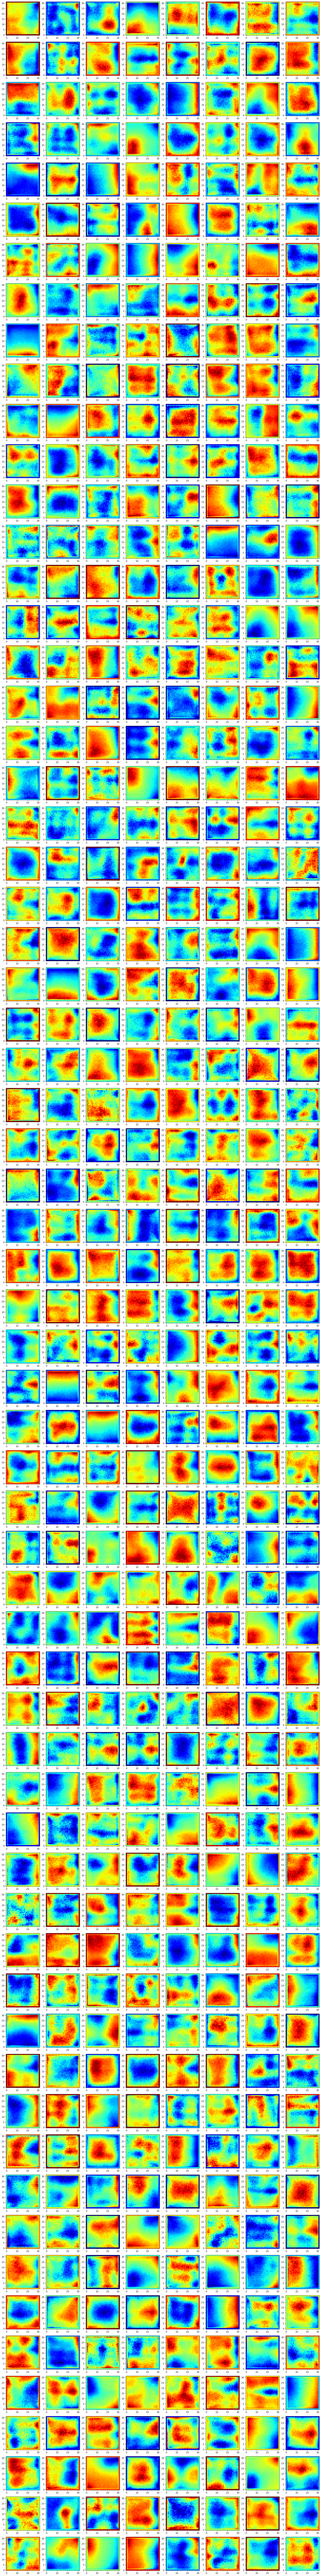

In [ ]:
visualize_activation_maps_random(model, place_cell_centers, hd_centers, arena_size, grid_res=32, T=T-5, n_paths=100000,
                                 velocity_mean=velocity_mean, velocity_std=velocity_std, angular_std=angular_std)

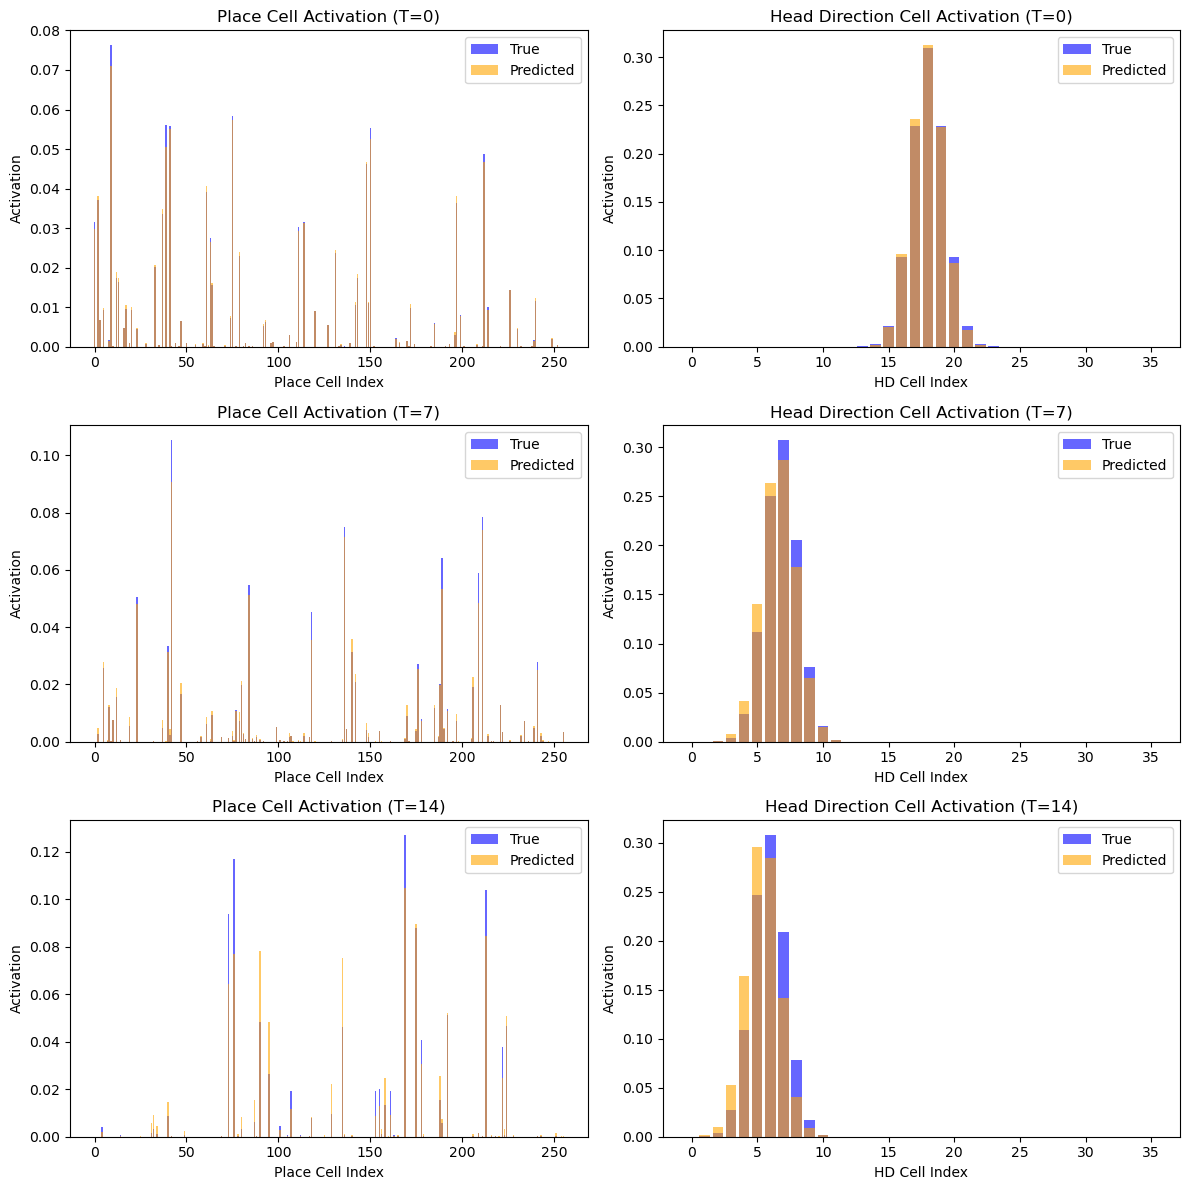

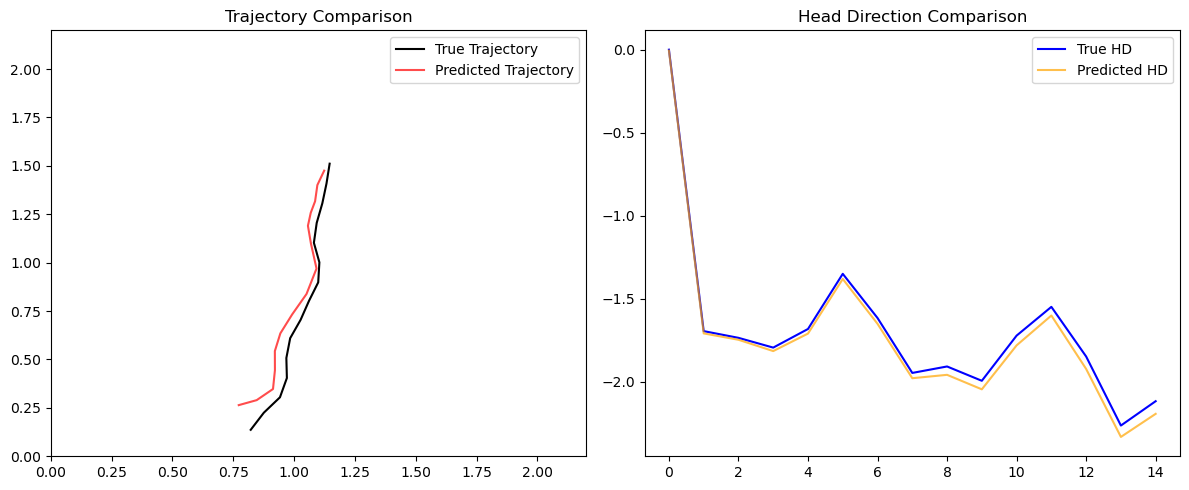

In [ ]:
trajectory = simulate_trajectory(T, arena_size,
                                 velocity_mean=velocity_mean, velocity_std=velocity_std, angular_std=angular_std)
place_target = get_place_encoding(trajectory, place_cell_centers)
vel = np.diff(trajectory, axis=0, prepend=trajectory[0:1]) / 0.1
angle = np.arctan2(vel[:, 1], vel[:, 0])
hd_target = get_hd_encoding(angle, hd_centers)

compare_place_hd_activation(model, trajectory, place_target, hd_target, vel, place_cell_centers, hd_centers)
evaluate_path_integration(model, trajectory, place_cell_centers, hd_centers, arena_size)